**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part II: BERT

Please see the description of the assignment in the README file (section 2) <br>
**Guide notebook**: [guides/bert_guide.ipynb](guides/bert_guide.ipynb)


***

<br>

* Note that you should report results using a classification report.

* Also, remember to include some reflections on your results: how do they compare with the results from Part I, BoW? Are there any hyperparameters that are particularly important?

* You should follow the steps given in the `bert_guide` notebook

* **Optionally**, you can fine-tune a pre-trained BERT model to classify news articles as is done in [guides/bert_guide_finetuning.ipybb](guides/bert_guide_finetuning.ipybb), the same task as in part 1. As this requires more computational resources, this part is optional. If you do decide to complete this part, you will need to use a GPU (e.g., Google Colab) to train the model. (For reference, training on a 2020 Macbook Pro with 16GB RAM and a M1 chip results in an out-of-memory error). Therefore, we suggest that you use Google Colab or another cloud-based service with a GPU. You can easily upload the `bert_guide_finetuning.ipynb` notebook to Google Colab and run it there.

<br>

***

#Install Dependencies

In [ ]:
!pip install huggingface_hub
!pip install datasets
!pip install torch
!pip install evaluate
!pip install accelerate
!pip install fastparquet
!pip install huggingface_hub

# Imports for the project

In [ ]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, ModernBertForSequenceClassification, pipeline, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression

### 1. Load the data

We can load this data directly from [Hugging Face Datasets](https://huggingface.co/docs/datasets/) - The HuggingFace Hub- into a Pandas DataFrame. Pretty neat!

**Note**: This cell will download the dataset and keep it in memory. If you run this cell multiple times, it will download the dataset multiple times.

You are welcome to increase the `frac` parameter to load more data.

In [ ]:
ag_news_train = load_dataset("fancyzhx/ag_news", split="train[:10%]")
ag_news_test = load_dataset("fancyzhx/ag_news", split="test[:20%]")
ag_news = DatasetDict({"train": ag_news_train, "test": ag_news_test})
ag_news

# Load ModernBERT tokenizer and model from HuggingFace

In [ ]:
# Define the mappping from label names to label ids
id2label = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

# Define the mapping from label ids to label names (the reverse of id2label)
label2id = {v: k for k, v in id2label.items()}

# load the model
model = ModernBertForSequenceClassification.from_pretrained("answerdotai/ModernBERT-base", num_labels=4, id2label=id2label, label2id=label2id)

# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")

# Tokenize and encode the data

In [ ]:
def preprocess_function(examples):
    """ Tokenize the text column in the examples. """
    return tokenizer(examples["text"], truncation=True)

tokenized_ag_news = ag_news.map(preprocess_function, batched=True, batch_size=4)

# Set evaluation metric

In [ ]:
f1 = evaluate.load("f1")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, predictions, average='weighted')  # 'weighted' for multiclass
    return {"f1": f1}

# Define a data collator and mount Google Drive

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

from google.colab import drive
drive.mount('/content/drive')

# Train the model

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/AIML_2025/ma2/my_awesome_model",  # THIS NEEDS TO CHANGE ON GOOGLE COLAB: "/content/drive/MyDrive/Colab Notebooks/my_awesome_model" or similar. Please check the path.
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.025,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ag_news["train"],
    eval_dataset=tokenized_ag_news["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# Evaluate the model

In [ ]:
train_predictions = trainer.predict(tokenized_ag_news["train"])
test_predictions = trainer.predict(tokenized_ag_news["test"])

# Extract predictions and labels
train_preds, train_labels = train_predictions.predictions.argmax(axis=1), train_predictions.label_ids
test_preds, test_labels = test_predictions.predictions.argmax(axis=1), test_predictions.label_ids

# Classification report for train dataset
print("Train Classification Report:")
print(classification_report(train_labels, train_preds))

# Classification report for test dataset
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

## Ananlysis

To avoid computational problems while running MODERNBERT, we used google collab, and ran the file using GPU.



Hyperparameters:
- Incresing learning rate led to the fluctuation of learning performance, using lower learning rate resulted in lower accuracy
- Increased the num_train_epochs to allow the model to arrive at an optimal solution giving it more time to learn
- Increased the weight_decay parameter to introduce stronger regularization to prevent the model from overfitting and relying heavily on some neurons
- The train test split was corrected to only use a portion of the data to prevent long running times of training. Specifically we only used 10% of training data and 20% of testing data from the original split. This provides us with higher flexibility for training as well as a good ratio of testing data.


With the used hyperparameters, we achieved the following results:

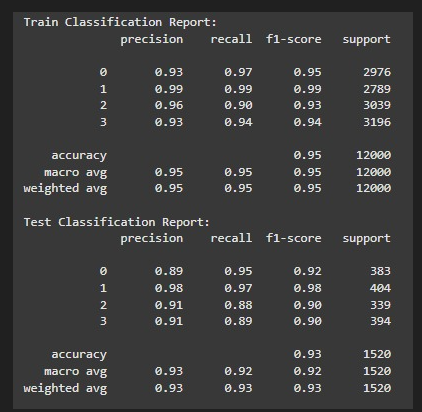

